In [1]:
import numpy as np
import pymc3 as pm

In [2]:
test_trajs = np.loadtxt(fname="test_data.txt", delimiter=",")

times = test_trajs[:, 0]
# we need the length of time spent in each row
dts = np.diff(times)

# we need to compare "states now" to "states next"
state_history = test_trajs[:, 1:].astype(np.int)
states_next = np.roll(state_history, shift=-1, axis=0)

# remove last entry to prevent off-by-one error
state_history = state_history[:-1, :]
states_next = states_next[:-1, :]

# 2D boolean arrays that appear in the likelihood
changes = state_history != states_next
is_s = (state_history == 0)
is_l = (state_history == 1)
is_i = (state_history == 2)
is_r = (state_history == 3)
# 1D integer array for number of ppl in infectious state at each interval
n_infected = is_i.sum(axis=1)

In [3]:
def negative_log_likelihood(x):
    gamma, zeta, xi = x
    qxus = ((is_s * n_infected[:, None] * gamma) +
            (is_l * zeta) + (is_i * xi))
    logls = np.log(qxus ** changes) - (qxus * dts[:, None])
    logl = logls.sum()

    return -logl

In [4]:
from scipy.optimize import minimize
bounds = [(0, np.inf), (0, np.inf), (0, np.inf)]

mle = minimize(negative_log_likelihood, x0=(1, 1, 1), bounds=bounds)
print(mle)

      fun: 418.72800976337373
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.84217094e-05, -1.13686838e-05, -1.70530257e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 44
      nit: 10
   status: 0
  success: True
        x: array([0.41231514, 0.85600939, 0.60539016])


In [5]:
with pm.Model() as the_model:
    pm_gamma = pm.HalfNormal("pm_gamma", sd=1)
    pm_zeta = pm.HalfNormal("pm_zeta", sd=1)
    pm_xi = pm.HalfNormal("pm_xi", sd=1)

    qxus = ((is_s * n_infected[:, None] * pm_gamma) +
            (is_l * pm_zeta) + (is_i * pm_xi))

    logls = pm.math.log(qxus ** changes) - (qxus * dts[:, None])
    logl = pm.math.sum(logls)

    potential = pm.Potential("potential", logl)
    trace = pm.sample(100, tune=100, discard_tuned_samples=False)

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [pm_xi, pm_zeta, pm_gamma]
Sampling 2 chains: 100%|██████████| 400/400 [00:01<00:00, 242.75draws/s]
The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 0.0, but should be close to 0.8. Try to increase the number of tuning steps.
The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 0.0, but should be close to 0.8. Try to increase the number of tuning steps.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.


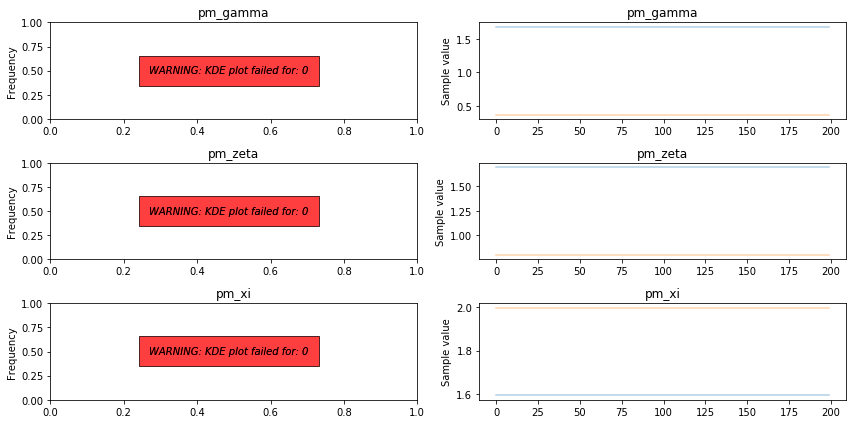

In [6]:
pm.traceplot(trace);

### Problematic gradient breaks the sampler

In [7]:
f = the_model.logp_dlogp_function()
f.set_extra_values({})
f(f.dict_to_array(the_model.test_point))

(array(-480.459848), array([nan, nan, nan]))

In [8]:
import theano.tensor as tt
dgamma, dzeta, dxi = tt.grad(logl, [pm_gamma, pm_zeta, pm_xi])

In [9]:
inputdict = {pm_gamma: mle['x'][0], pm_zeta: mle['x'][1], pm_xi: mle['x'][2]}
print(logl.eval(inputdict), dgamma.eval(inputdict),
      dzeta.eval(inputdict), dxi.eval(inputdict))

-418.7280097633918 nan nan nan


In [11]:
with the_model:
    step = pm.NUTS()
q0 = step.potential.random()
p0 = step._logp_dlogp_func.dict_to_array(the_model.test_point)
print(p0, q0)

[-0.22579135 -0.22579135 -0.22579135] [ 0.7325482   0.30594347 -0.45624465]


In [12]:
step.integrator.compute_state(q0, p0)

State(q=array([ 0.7325482 ,  0.30594347, -0.45624465]), p=array([-0.22579135, -0.22579135, -0.22579135]), v=array([-0.22579135, -0.22579135, -0.22579135]), q_grad=array([nan, nan, nan]), energy=690.1126486500195, model_logp=array(-690.03617605))

### Check where gradient breaks, and reparameterized

In [17]:
loss = pm.math.log(qxus ** changes.astype(float)).sum()
dgamma, dzeta, dxi = tt.grad(loss, [pm_gamma, pm_zeta, pm_xi])
print(loss.eval(inputdict), dgamma.eval(inputdict),
      dzeta.eval(inputdict), dxi.eval(inputdict))

140.2719692431427 nan nan nan


In [26]:
loss = tt.switch(changes, pm.math.log(qxus), 0.).sum()

dgamma, dzeta, dxi = tt.grad(loss, [pm_gamma, pm_zeta, pm_xi])
print(loss.eval(inputdict), dgamma.eval(inputdict),
      dzeta.eval(inputdict), dxi.eval(inputdict))

140.2719692431427 nan nan nan


In [27]:
loss = pm.math.log(qxus[changes]).sum()

dgamma, dzeta, dxi = tt.grad(loss, [pm_gamma, pm_zeta, pm_xi])
print(loss.eval(inputdict), dgamma.eval(inputdict),
      dzeta.eval(inputdict), dxi.eval(inputdict))

140.2719692431427 451.11125744749626 217.28733567145977 308.8917065049014


In [30]:
x = tt.zeros(qxus.shape)
x = tt.inc_subtensor(x[changes], pm.math.log(qxus[changes]))
x = tt.inc_subtensor(x[~changes], pm.math.log(1.))

loss = x.sum()

dgamma, dzeta, dxi = tt.grad(loss, [pm_gamma, pm_zeta, pm_xi])
print(loss.eval(inputdict), dgamma.eval(inputdict),
      dzeta.eval(inputdict), dxi.eval(inputdict))

140.2719692431427 451.11125744749626 217.28733567145977 308.8917065049014


### Implement a version that does not break the gradient

In [31]:
def logp(gamma, zeta, xi):
    qxus = ((is_s * n_infected[:, None] * gamma) +
            (is_l * zeta) + (is_i * xi))
    x = tt.zeros(qxus.shape)
    x = tt.inc_subtensor(x[changes], qxus[changes])
    x = tt.inc_subtensor(x[~changes], 1.)

    logls = pm.math.log(x) - (qxus * dts[:, None])
    return pm.math.sum(logls)

In [32]:
print(-negative_log_likelihood(mle['x']))

-418.72800976337373


In [33]:
print(logp(mle['x'][0], mle['x'][1], mle['x'][2]).eval())

-418.7280097633918


In [34]:
loss = logp(pm_gamma, pm_zeta, pm_xi)
dgamma, dzeta, dxi = tt.grad(loss, [pm_gamma, pm_zeta, pm_xi])
print(loss.eval(inputdict), dgamma.eval(inputdict),
      dzeta.eval(inputdict), dxi.eval(inputdict))

-418.7280097633918 2.986196361653981e-05 2.7578333883226946e-07 1.3949472150942555e-05


In [35]:
with pm.Model() as the_model:
    gamma = pm.HalfNormal("gamma", sd=1)
    zeta = pm.HalfNormal("zeta", sd=1)
    xi = pm.HalfNormal("xi", sd=1)

    potential = pm.DensityDist("potential",
                               logp,
                               observed={"gamma": gamma,
                                         "zeta": zeta,
                                         "xi": xi})

In [36]:
the_model.test_point

{'gamma_log__': array(-0.22579135),
 'zeta_log__': array(-0.22579135),
 'xi_log__': array(-0.22579135)}

In [37]:
the_model.check_test_point()

gamma_log__     -0.77
zeta_log__      -0.77
xi_log__        -0.77
potential     -478.15
Name: Log-probability of test_point, dtype: float64

In [38]:
with the_model:
    mle = pm.find_MAP()
mle

/home/junpenglao/Documents/pymc3/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -479.78, ||grad|| = 185.02: 100%|██████████| 8/8 [00:00<00:00, 56.88it/s]   


{'gamma_log__': array(-0.88688001),
 'zeta_log__': array(-0.15939038),
 'xi_log__': array(-0.50383623),
 'gamma': array(0.411939),
 'zeta': array(0.85266343),
 'xi': array(0.60420833)}

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [xi, zeta, gamma]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:56<00:00, 35.36draws/s]


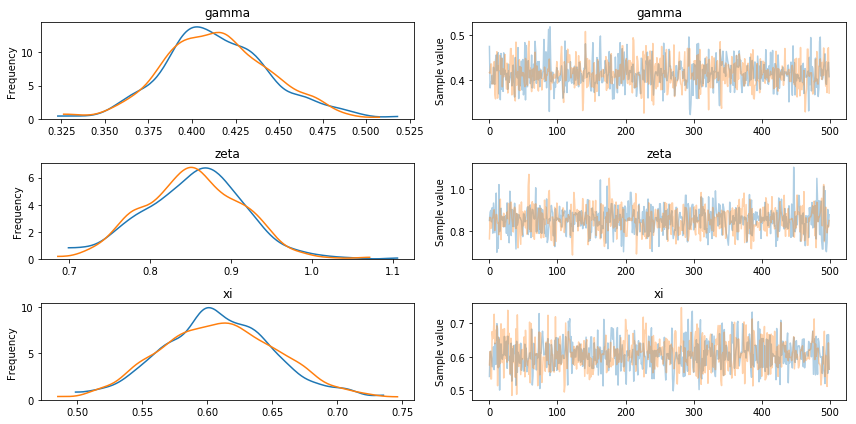

In [39]:
with the_model:
    trace = pm.sample()
    
pm.traceplot(trace);